In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from models import WorldModel
from dataset import create_wall_dataloader
import os

In [5]:
class CNNVisualizer:
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()
        
    def _enhance_activation_map(self, activation, method='both', percentile=80):
        """
        Enhance activation map visibility using various methods
        Args:
            activation: numpy array of activations
            method: 'threshold', 'softmax', or 'both'
            percentile: percentile value for thresholding
        """
        if method == 'threshold':
            threshold = np.percentile(activation, percentile)
            enhanced = np.where(activation > threshold, activation, 0)
            if enhanced.max() != enhanced.min():
                enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min())
            
        elif method == 'softmax':
            flattened = activation.flatten()
            softmaxed = F.softmax(torch.tensor(flattened) / 0.1, dim=0).numpy()
            enhanced = softmaxed.reshape(activation.shape)
            
        elif method == 'both':
            threshold = np.percentile(activation, percentile)
            thresholded = np.where(activation > threshold, activation, 0)
            flattened = thresholded.flatten()
            softmaxed = F.softmax(torch.tensor(flattened) / 0.1, dim=0).numpy()
            enhanced = softmaxed.reshape(activation.shape)
            
        return enhanced
    
    def visualize_feature_maps(self, input_state, input_action=None, layer_name='conv1', enhance_method='both'):
        """
        Visualize feature maps from a specific convolutional layer
        Args:
            input_state: Input tensor of shape [B, T, C, H, W] or [B, C, H, W]
            input_action: [B, T-1, 2] tensor (optional)
            layer_name: name of layer to visualize ('conv1' or 'conv2' for encoder)
            enhance_method: method to enhance activation visibility
        """
        # Get a single state to visualize (first timestep if sequence input)
        if input_state.dim() == 5:  # [B, T, C, H, W]
            input_state = input_state[:, 0]  # Take first timestep -> [B, C, H, W]
            
        activations = {}
        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output.detach()
            return hook

        if layer_name == 'conv1':
            self.model.encoder.conv1.register_forward_hook(get_activation('conv1'))
        elif layer_name == 'conv2':
            self.model.encoder.conv2.register_forward_hook(get_activation('conv2'))
            
        with torch.no_grad():
            _ = self.model.encoder(input_state)
        
        feature_maps = activations[layer_name][0].cpu().numpy()  # Take first batch item
        n_features = feature_maps.shape[0]
        size = int(np.ceil(np.sqrt(n_features)))
        
        fig = plt.figure(figsize=(20, 20))
        for i in range(n_features):
            enhanced_map = self._enhance_activation_map(feature_maps[i], method=enhance_method)
            
            ax = plt.subplot(size, size, i + 1)
            im = plt.imshow(enhanced_map, cmap='viridis')
            plt.colorbar(im)
            plt.axis('off')
            plt.title(f'Filter {i+1}')
        
        plt.suptitle(f'{layer_name} Feature Maps (Enhanced with {enhance_method})')
        plt.tight_layout()
        return plt.gcf()
    
    def visualize_kernel_weights(self, layer_name='conv1', enhance_method='both'):
        """
        Visualize convolutional kernel weights
        Args:
            layer_name: name of layer to visualize ('conv1' or 'conv2')
            enhance_method: method to enhance weight visibility
        """
        if layer_name == 'conv1':
            weights = self.model.encoder.conv1.weight.data.cpu()
        elif layer_name == 'conv2':
            weights = self.model.encoder.conv2.weight.data.cpu()
        
        out_channels, in_channels, k_h, k_w = weights.shape
        
        fig, axes = plt.subplots(out_channels, in_channels, 
                                figsize=(in_channels*3, out_channels*3))
        
        if out_channels == 1:
            axes = axes[np.newaxis, :]
        if in_channels == 1:
            axes = axes[:, np.newaxis]
        
        # Plot each kernel
        for i in range(out_channels):
            for j in range(in_channels):
                kernel = weights[i, j].numpy()
                enhanced_kernel = self._enhance_activation_map(kernel, method=enhance_method)
                
                im = axes[i, j].imshow(enhanced_kernel, cmap='viridis')
                plt.colorbar(im, ax=axes[i, j])
                axes[i, j].axis('off')
                if i == 0:
                    if j == 0:
                        axes[i, j].set_title('Walls Channel')
                    elif j == 1:
                        axes[i, j].set_title('Agent Channel')
        
        plt.suptitle(f'{layer_name} Kernels (Enhanced with {enhance_method})\nRows: Output Channels, Columns: Input Channels')
        plt.tight_layout()
        return plt.gcf()

    def visualize_saliency_maps(self, input_state, input_action):
        """
        Generate saliency maps showing which input pixels are most important
        Args:
            input_state: [1, 1, 2, H, W] tensor (sequence format)
            input_action: [1, T-1, 2] tensor
        """
        gradients = self.compute_activation_gradients(input_state, input_action)
        
        # Get original input images
        input_walls = input_state.squeeze(1)[0, 0].cpu().numpy()
        input_agent = input_state.squeeze(1)[0, 1].cpu().numpy()
        
        # Enhance gradients
        walls_gradients = np.abs(gradients[0, 0])
        agent_gradients = np.abs(gradients[0, 1])
        enhanced_walls = self._enhance_activation_map(walls_gradients, method='both')
        enhanced_agent = self._enhance_activation_map(agent_gradients, method='both')
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # Plot original inputs
        axes[0, 0].imshow(input_walls, cmap='gray')
        axes[0, 0].set_title('Original Walls/Doors')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(input_agent, cmap='gray')
        axes[0, 1].set_title('Original Agent Position')
        axes[0, 1].axis('off')
        
        # Plot enhanced saliency maps
        walls_map = axes[1, 0].imshow(enhanced_walls, cmap='hot')
        axes[1, 0].set_title('Walls Channel Saliency\n(Brighter = More Important)')
        axes[1, 0].axis('off')
        plt.colorbar(walls_map, ax=axes[1, 0])
        
        agent_map = axes[1, 1].imshow(enhanced_agent, cmap='hot')
        axes[1, 1].set_title('Agent Channel Saliency\n(Brighter = More Important)')
        axes[1, 1].axis('off')
        plt.colorbar(agent_map, ax=axes[1, 1])
        
        plt.tight_layout()
        return plt.gcf()
    
    def compute_activation_gradients(self, input_state, input_action, target_layer='conv2'):
        """Helper method for saliency maps"""
        input_state = input_state.clone()
        input_state.requires_grad_()
        
        x = input_state.squeeze(1)
        
        if target_layer == 'conv1':
            activations = self.model.encoder.conv1(x)
        elif target_layer == 'conv2':
            x = F.relu(self.model.encoder.bn1(self.model.encoder.conv1(x)))
            activations = self.model.encoder.conv2(x)
            
        activation_mean = activations.mean()
        activation_mean.backward()
        
        return input_state.grad.squeeze(1).cpu().numpy()

In [9]:
def load_trained_model(checkpoint_path, loss_type='combined'):
    """
    Load a trained WorldModelVICReg from a checkpoint
    """
    # Initialize model with same parameters as training
    model = WorldModel(
        loss_type=loss_type,
    )
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model

def get_sample_batch(data_path="/drive_reader/as16386/DL24FA/train", batch_size=1):
    """
    Get a sample batch from the dataset
    """
    loader = create_wall_dataloader(
        data_path=data_path,
        probing=False,
        device="cuda",
        batch_size=batch_size,
        train=False,
        num_samples=batch_size
    )
    return next(iter(loader))

def visualize_model():
    # Set parameters
    checkpoint_dir = "checkpoints/baseline_combined_lr_reduced"  # Replace with your wandb run name

    latest_checkpoint = 'checkpoint_epoch_87.pt' 
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    # Load model
    model = load_trained_model(checkpoint_path, loss_type='both')  # or 'barlow' depending on your training
    model = model.cuda()
    
    # Get a sample batch
    batch = get_sample_batch()
    input_state = batch.states[:, :2].cuda()  # Get just the first state
    input_action = batch.actions.cuda()
    
    # Initialize visualizer
    visualizer = CNNVisualizer(model)
    
    # 1. Visualize encoder's first conv layer feature maps
    print("Generating encoder conv1 feature maps...")
    encoder_conv1_maps = visualizer.visualize_feature_maps(input_state[:,0], layer_name='conv1')
    encoder_conv1_maps.savefig('encoder_conv1_features.png')
    plt.close()
    
    # 2. Visualize encoder's second conv layer feature maps
    print("Generating encoder conv2 feature maps...")
    encoder_conv2_maps = visualizer.visualize_feature_maps(input_state[:,0], layer_name='conv2')
    encoder_conv2_maps.savefig('encoder_conv2_features.png')
    plt.close()
    
    # 3. Generate saliency maps
    print("Generating saliency maps...")
    saliency_maps = visualizer.visualize_saliency_maps(input_state, input_action)
    saliency_maps.savefig('saliency_maps.png')
    plt.close()
    
    # 4. Visualize convolutional kernels
    print("Generating kernel visualizations...")
    conv1_kernels = visualizer.visualize_kernel_weights(layer_name='conv1')
    conv1_kernels.savefig('conv1_kernels.png')
    plt.close()
    
    conv2_kernels = visualizer.visualize_kernel_weights(layer_name='conv2')
    conv2_kernels.savefig('conv2_kernels.png')
    plt.close()

if __name__ == "__main__":
    visualize_model()

/tmp/ipykernel_3427950/1956898384.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Generating encoder conv1 feature maps...
Generating encoder conv2 feature maps...
Generating saliency maps...


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 2, 2, 65, 65]

In [10]:
class PredictorVisualizer:
    def __init__(self, model, device='cuda'):
        self.model = model
        self.device = device
        self.model.eval()
    
    def _enhance_activation_map(self, activation, method='threshold', percentile=80):
        """
        Enhance activation map visibility using various methods
        Args:
            activation: numpy array of activations
            method: 'threshold', 'softmax', or 'both'
            percentile: percentile value for thresholding
        """
        if method == 'threshold':
            # Zero out values below threshold
            threshold = np.percentile(activation, percentile)
            enhanced = np.where(activation > threshold, activation, 0)
            # Normalize to [0, 1]
            if enhanced.max() != enhanced.min():
                enhanced = (enhanced - enhanced.min()) / (enhanced.max() - enhanced.min())
            
        elif method == 'softmax':
            # Apply softmax to create more separation
            flattened = activation.flatten()
            softmaxed = F.softmax(torch.tensor(flattened) / 0.1, dim=0).numpy()
            enhanced = softmaxed.reshape(activation.shape)
            
        elif method == 'both':
            # Combine both methods
            threshold = np.percentile(activation, percentile)
            thresholded = np.where(activation > threshold, activation, 0)
            flattened = thresholded.flatten()
            softmaxed = F.softmax(torch.tensor(flattened) / 0.1, dim=0).numpy()
            enhanced = softmaxed.reshape(activation.shape)
            
        return enhanced
    
    def visualize_prediction_sequence(self, input_state, actions, num_steps=5, enhance_method='both'):
        """
        Visualize how the predictor transforms states over multiple timesteps
        Args:
            input_state: [1, 1, 2, H, W] initial state
            actions: [1, T, 2] sequence of actions
            num_steps: number of steps to visualize
            enhance_method: method to enhance activation visibility
        """
        num_steps = min(num_steps, actions.shape[1])
        
        with torch.no_grad():
            predictions = self.model.forward_prediction(input_state, actions)
            
            fig, axes = plt.subplots(num_steps, 4, figsize=(20, 4*num_steps))
            
            # For t=0, show the initial state
            axes[0, 0].imshow(input_state.squeeze(1)[0, 0].cpu().numpy(), cmap='gray')
            axes[0, 0].set_title('Initial Walls/Doors')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(input_state.squeeze(1)[0, 1].cpu().numpy(), cmap='gray')
            axes[0, 1].set_title('Initial Agent Position')
            axes[0, 1].axis('off')
            
            action = actions[0, 0].cpu().numpy()
            axes[0, 2].text(0.5, 0.5, f'Action: [{action[0]:.2f}, {action[1]:.2f}]', 
                          horizontalalignment='center')
            axes[0, 2].set_title('Action Applied')
            axes[0, 2].axis('off')
            
            axes[0, 3].text(0.5, 0.5, 'Initial State', horizontalalignment='center')
            axes[0, 3].axis('off')
            
            # For each subsequent timestep
            for t in range(1, num_steps):
                pred_encoding = predictions[:, t]  # Shape: [1, 32, 8, 8]
                
                # Enhance and plot wall features
                wall_encoding = pred_encoding[:, :16].mean(dim=1).squeeze(0).cpu().numpy()
                enhanced_wall = self._enhance_activation_map(wall_encoding, method=enhance_method)
                wall_im = axes[t, 0].imshow(enhanced_wall, cmap='viridis')
                axes[t, 0].set_title(f'T{t} Wall Features')
                axes[t, 0].axis('off')
                plt.colorbar(wall_im, ax=axes[t, 0])
                
                # Enhance and plot agent features
                agent_encoding = pred_encoding[:, 16:].mean(dim=1).squeeze(0).cpu().numpy()
                enhanced_agent = self._enhance_activation_map(agent_encoding, method=enhance_method)
                agent_im = axes[t, 1].imshow(enhanced_agent, cmap='viridis')
                axes[t, 1].set_title(f'T{t} Agent Features')
                axes[t, 1].axis('off')
                plt.colorbar(agent_im, ax=axes[t, 1])
                
                # Show action
                action = actions[0, t-1].cpu().numpy()
                axes[t, 2].text(0.5, 0.5, f'Action: [{action[0]:.2f}, {action[1]:.2f}]', 
                              horizontalalignment='center')
                axes[t, 2].set_title('Action Applied')
                axes[t, 2].axis('off')
                
                # Enhance and plot mean activation
                mean_activation = pred_encoding.mean(dim=1).squeeze(0).cpu().numpy()
                enhanced_mean = self._enhance_activation_map(mean_activation, method=enhance_method)
                mean_im = axes[t, 3].imshow(enhanced_mean, cmap='viridis')
                axes[t, 3].set_title(f'T{t} Mean Activation')
                axes[t, 3].axis('off')
                plt.colorbar(mean_im, ax=axes[t, 3])
                
            plt.tight_layout()
            return plt.gcf()
    
    def visualize_action_embeddings(self, input_state, actions, enhance_method='both'):
        """
        Visualize how the predictor embeds actions into the spatial domain
        """
        with torch.no_grad():
            B, _, H, W = input_state.squeeze(1).shape
            action = actions[:, 0]
            action_spatial = action.view(B, 2, 1, 1).expand(-1, -1, H, W)
            action_embedding = self.model.predictor.action_embed(action_spatial)
            
            fig, axes = plt.subplots(2, 8, figsize=(20, 5))
            for i in range(16):
                row = i // 8
                col = i % 8
                embedding = action_embedding[0, i].cpu().numpy()
                enhanced = self._enhance_activation_map(embedding, method=enhance_method)
                im = axes[row, col].imshow(enhanced, cmap='viridis')
                axes[row, col].set_title(f'Channel {i+1}')
                axes[row, col].axis('off')
                plt.colorbar(im, ax=axes[row, col])
            
            plt.suptitle(f'Action Embedding Channels for action: [{action[0,0]:.2f}, {action[0,1]:.2f}]')
            plt.tight_layout()
            return plt.gcf()
    
    def visualize_transition_layers(self, input_state, actions, enhance_method='both'):
        """
        Visualize activations in the transition model layers
        """
        activations = {}
        
        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output.detach()
            return hook
        
        handles = []
        for name, module in self.model.predictor.transition.named_children():
            if isinstance(module, torch.nn.Conv2d):
                handles.append(module.register_forward_hook(get_activation(name)))
        
        with torch.no_grad():
            _ = self.model.forward_prediction(input_state, actions)
        
        for handle in handles:
            handle.remove()
        
        fig = plt.figure(figsize=(20, 10))
        for idx, (name, activation) in enumerate(activations.items()):
            mean_activation = activation[0].mean(dim=0).cpu().numpy()
            enhanced = self._enhance_activation_map(mean_activation, method=enhance_method)
            
            plt.subplot(1, len(activations), idx+1)
            im = plt.imshow(enhanced, cmap='viridis')
            plt.title(f'Transition Layer {idx+1}\nMean Activation')
            plt.colorbar(im)
            plt.axis('off')
        
        plt.tight_layout()
        return plt.gcf()

/tmp/ipykernel_3427950/1956898384.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


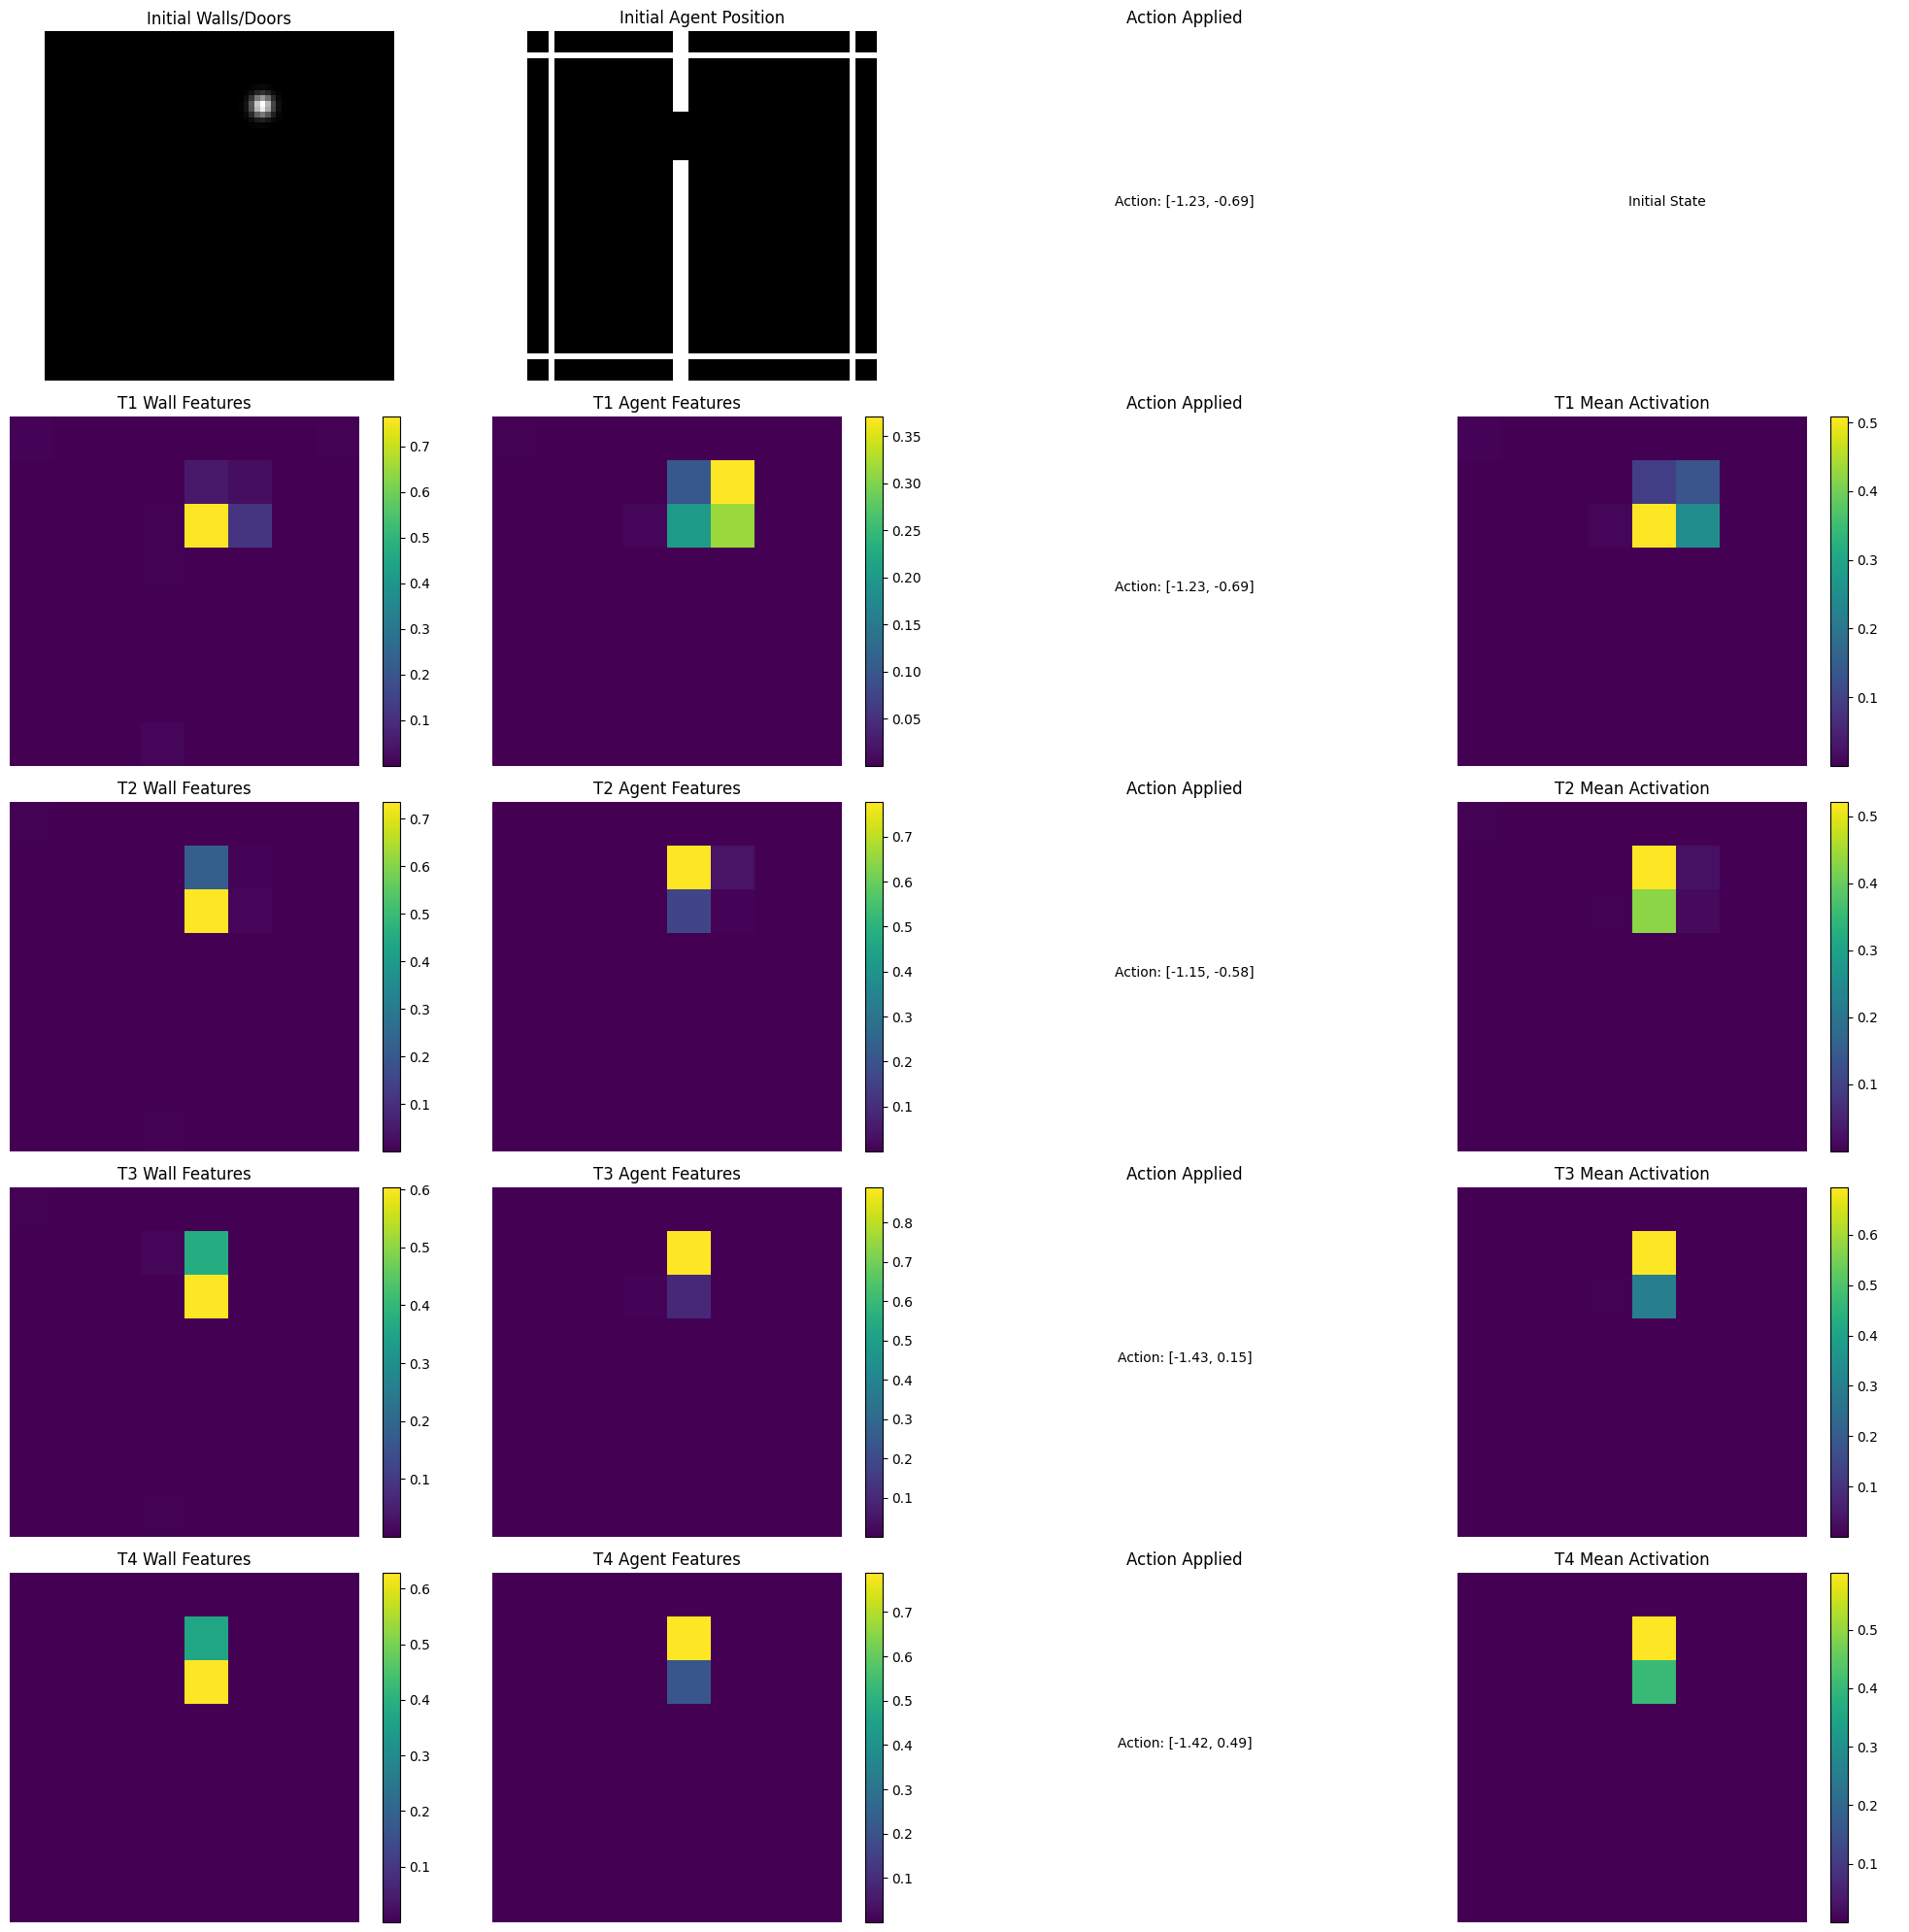

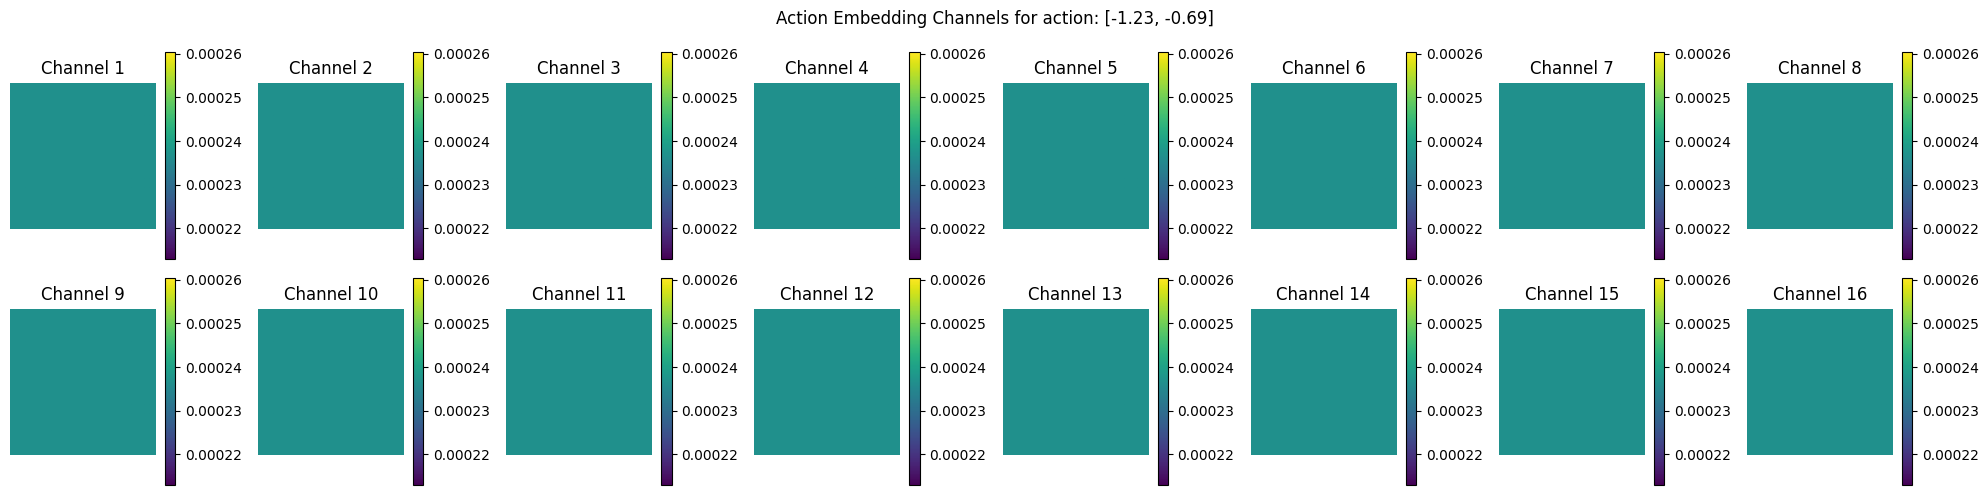

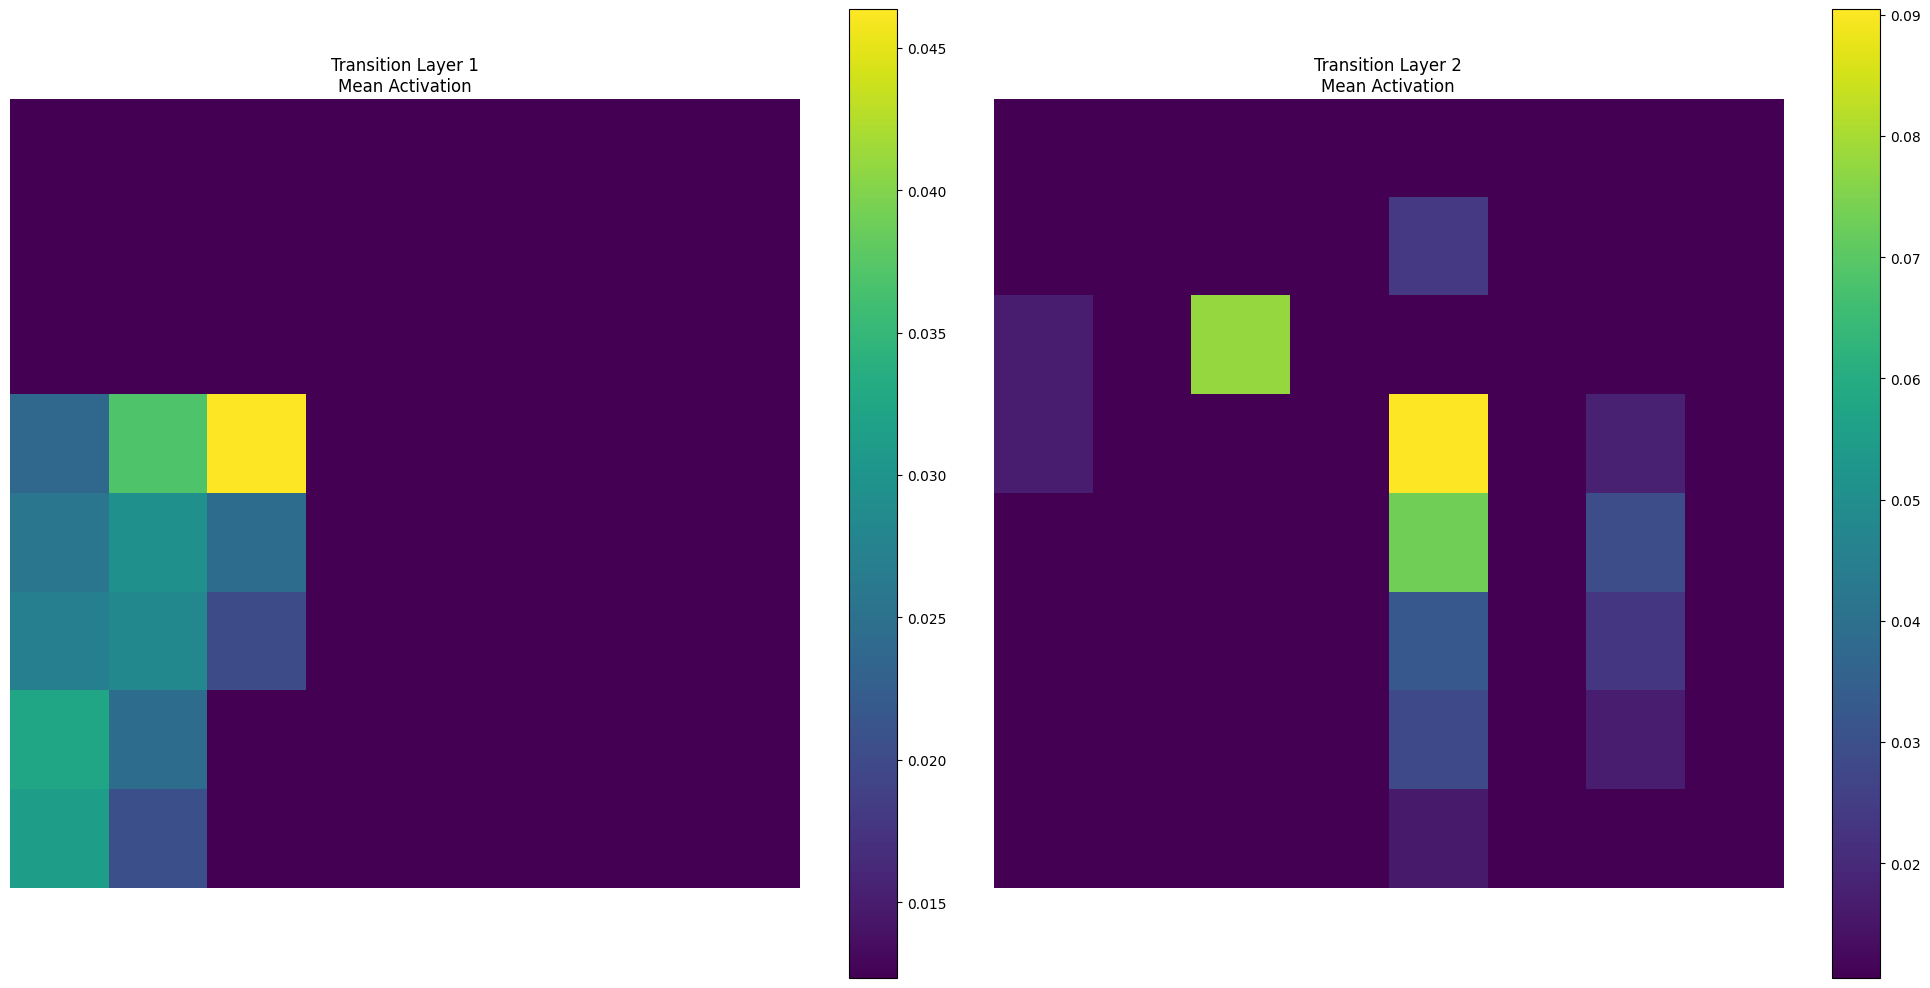

In [12]:
checkpoint_dir ="checkpoints/baseline_combined_lr_reduced"  # Replace with your wandb run name
latest_checkpoint = 'checkpoint_epoch_87.pt' 
checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)

# Load model
model = load_trained_model(checkpoint_path, loss_type='both')  # or 'barlow' depending on your training
model = model.cuda()

# Get a sample batch
batch = get_sample_batch()
input_state = batch.states[:, 0:1].cuda()  # Get just the first state
input_action = batch.actions.cuda()

# Create visualizer
predictor_viz = PredictorVisualizer(model)

# 1. Visualize prediction sequence
sequence_viz = predictor_viz.visualize_prediction_sequence(input_state, input_action, num_steps=5)
plt.show()

# 2. Visualize action embeddings
action_viz = predictor_viz.visualize_action_embeddings(input_state, input_action)
plt.show()

# 3. Visualize transition layer activations
transition_viz = predictor_viz.visualize_transition_layers(input_state, input_action)
plt.show()